# Installing dependencies

Please make a copy of this notebook.


# Huggingface login
You will require your personal token.

# Data

## Downloading the train and test dataset

In [1]:
from datasets import load_dataset, DatasetDict, Features, Image, Value
import os

# 1. Point to the root folder that contains both train/ and test/ subfolders
ROOT_DIR  = r"C:\Users\Xiang\Downloads\drive-download-20250422T155327Z-001"
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
TEST_DIR  = os.path.join(ROOT_DIR, "test")

# 2. Load both CSVs at once into a DatasetDict
data_files = {
    "train": os.path.join(TRAIN_DIR, "metadata.csv"),
    "test":  os.path.join(TEST_DIR,  "metadata.csv"),
}
ds = load_dataset(
    "csv",
    data_files=data_files,
    delimiter=","
)  # → DatasetDict({'train': Dataset(...), 'test': Dataset(...)})

# 3. Define two small mapping functions to add the full image path
def add_train_image(example):
    return {"image": os.path.join(TRAIN_DIR, example["file_name"])}

def add_test_image(example):
    return {"image": os.path.join(TEST_DIR,  example["file_name"])}

# 4. Map them to each split
ds["train"] = ds["train"].map(add_train_image)
ds["test"]  = ds["test"].map(add_test_image)

# 5. Tell 🤗 Datasets what each column really is
features = Features({
    "file_name": Value("string"),   # keep it around if you like
    "image":     Image(),           # will load via PIL on access
    "Latitude":  Value("float32"),
    "Longitude": Value("float32"),
})
ds = ds.cast(features)

# 6. (Optional) drop the original filename column now that "image" exists
ds["train"] = ds["train"].remove_columns("file_name")
ds["test"]  = ds["test"].remove_columns("file_name")

print(ds)


DatasetDict({
    train: Dataset({
        features: ['image', 'Latitude', 'Longitude'],
        num_rows: 673
    })
    test: Dataset({
        features: ['image', 'Latitude', 'Longitude'],
        num_rows: 260
    })
})


In [2]:
dataset_train = ds["train"]
dataset_test = ds["test"]

## Defining the Custom Dataset Class

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification
from huggingface_hub import PyTorchModelHubMixin
from PIL import Image
import os
import numpy as np

class CustomResNetModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, model_name="microsoft/resnet-50", num_outputs=2, dropout_p=0.3, freeze_backbone=True):
        super().__init__()

        self.backbone = AutoModelForImageClassification.from_pretrained(model_name)

        if freeze_backbone:                       # optional fine‑tuning switch
            for p in self.backbone.parameters():
                p.requires_grad_(False)

        # 2048 = channels after global avg‑pool in ResNet‑152
        in_features = self.backbone.classifier[1].in_features

        self.backbone.classifier = nn.Identity()  # strip old head

        self.head = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),

            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),

            nn.Linear(512, num_outputs)           # (lat, lon) z‑scores
        )

    def forward(self, x):
        feats = self.backbone(x).logits        # tensor, shape (B, 2048, 1, 1) or (B, 2048)

        # flatten in case it still has H and W dims
        if feats.ndim > 2:
            feats = feats.flatten(1)           # -> (B, 2048)

        return self.head(feats)

    def save_model(self, save_path):
        """Save model locally using the Hugging Face format."""
        self.save_pretrained(save_path)

    def push_model(self, repo_name):
        """Push the model to the Hugging Face Hub."""
        self.push_to_hub(repo_name)

class GPSImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

        # Compute mean and std from the dataframe if not provided
        self.latitude_mean = lat_mean if lat_mean is not None else np.mean(np.array(self.hf_dataset['Latitude']))
        self.latitude_std = lat_std if lat_std is not None else np.std(np.array(self.hf_dataset['Latitude']))
        self.longitude_mean = lon_mean if lon_mean is not None else np.mean(np.array(self.hf_dataset['Longitude']))
        self.longitude_std = lon_std if lon_std is not None else np.std(np.array(self.hf_dataset['Longitude']))

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Extract data
        example = self.hf_dataset[idx]

        # Load and process the image
        image = example['image']
        latitude = example['Latitude']
        longitude = example['Longitude']
        # image = image.rotate(-90, expand=True)
        if self.transform:
            image = self.transform(image)

        # Normalize GPS coordinates
        latitude = (latitude - self.latitude_mean) / self.latitude_std
        longitude = (longitude - self.longitude_mean) / self.longitude_std
        gps_coords = torch.tensor([latitude, longitude], dtype=torch.float32)

        return image, gps_coords

## Creating dataloaders and visualizing the data

In [4]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(degrees=15),  # Random rotation between -15 and 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Optionally, you can create a separate transform for inference without augmentations
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



# Create the training dataset and dataloader
train_dataset = GPSImageDataset(hf_dataset=dataset_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Retrieve normalization parameters from the training dataset
lat_mean = train_dataset.latitude_mean
lat_std = train_dataset.latitude_std
lon_mean = train_dataset.longitude_mean
lon_std = train_dataset.longitude_std

# Create the validation dataset and dataloader using training mean and std
val_dataset = GPSImageDataset(
    hf_dataset=dataset_test,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [5]:
# Verify loading
for images, gps_coords in train_dataloader:
    print(images.size(), gps_coords.size())
    break

torch.Size([64, 3, 224, 224]) torch.Size([64, 2])


In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    tensor = tensor.numpy().transpose((1, 2, 0))  # Convert from C x H x W to H x W x C
    tensor = std * tensor + mean  # Denormalize
    tensor = np.clip(tensor, 0, 1)  # Clip to keep pixel values between 0 and 1
    return tensor

data_iter = iter(train_dataloader)
images, gps_coords = next(data_iter)  # Get a batch of images and labels
# Denormalize the first image in the batch for display
itr = 0
# for im in images:
#   image = denormalize(im, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#   # Plot the image
#   plt.imshow(image)
#   plt.title(f'Latitude: {gps_coords[itr][0].item():.4f}, Longitude: {gps_coords[itr][1].item():.4f}')
#   plt.axis('off')
#   plt.show()
#   itr += 1

# Resnet

In [ ]:
import torch.nn as nn
import torch.optim as optim
from geopy.distance import geodesic
from torch.optim.lr_scheduler import StepLR
from transformers import AutoImageProcessor, AutoModelForImageClassification

# ====================== Or You can load resnet from HuggingFace usting the custom model class =============================
# NOTE THAT YOU MIGHT NEED TO MODIFY THE IMPLEMENTATION OF CUSTOM MODEL CLASS
resnet = CustomResNetModel()
# ============================================================================================

# Define the loss function and optimizer
criterion = nn.MSELoss()
# If not fine tuning
# optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001)
# If fine tuning
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

# Add a learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
resnet = resnet.to(device)

# Training loop with validation
lowest_val_loss = float('inf')
num_epochs = 10
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, gps_coords in train_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, gps_coords)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet.eval()
    val_loss = 0.0
    baseline_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, gps_coords in val_dataloader:
            images = images.to(device)
            gps_coords = gps_coords.to(device)

            batch_size = gps_coords.size(0)
            total_samples += batch_size

            # Model predictions
            outputs = resnet(images)

            # Denormalize predictions and actual GPS coordinates
            preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
            actuals_denorm = gps_coords.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

            # Compute geodesic distances between predictions and actuals
            for pred, actual in zip(preds_denorm, actuals_denorm):
                distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                val_loss += distance ** 2  # Squared distance

            # Baseline predictions
            baseline_preds = np.array([lat_mean, lon_mean])

            # Compute geodesic distances between baseline preds and actuals
            for actual in actuals_denorm:
                distance = geodesic((actual[0], actual[1]), (baseline_preds[0], baseline_preds[1])).meters
                baseline_loss += distance ** 2  # Squared distance

    # Compute average losses
    val_loss /= total_samples
    baseline_loss /= total_samples

    # Compute RMSE
    val_rmse = np.sqrt(val_loss)
    baseline_rmse = np.sqrt(baseline_loss)

    # Check if the current validation loss is lower than the lowest recorded loss
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        # Save the model with the best validation loss
        torch.save(resnet.state_dict(), 'best_custom_model.pth')

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss (meters^2): {val_loss:.2f}, Baseline Loss (meters^2): {baseline_loss:.2f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation RMSE (meters): {val_rmse:.2f}, Baseline RMSE (meters): {baseline_rmse:.2f}")

print('Training complete')

Using device: cuda
Epoch [1/10], Training Loss: 1.0308
Epoch [1/10], Validation Loss (meters^2): 8925.81, Baseline Loss (meters^2): 9346.45
Epoch [1/10], Validation RMSE (meters): 94.48, Baseline RMSE (meters): 96.68
Epoch [2/10], Training Loss: 0.9246
Epoch [2/10], Validation Loss (meters^2): 8294.20, Baseline Loss (meters^2): 9346.45
Epoch [2/10], Validation RMSE (meters): 91.07, Baseline RMSE (meters): 96.68
Epoch [3/10], Training Loss: 0.7914
Epoch [3/10], Validation Loss (meters^2): 7679.60, Baseline Loss (meters^2): 9346.45
Epoch [3/10], Validation RMSE (meters): 87.63, Baseline RMSE (meters): 96.68
Epoch [4/10], Training Loss: 0.7610
Epoch [4/10], Validation Loss (meters^2): 6829.91, Baseline Loss (meters^2): 9346.45
Epoch [4/10], Validation RMSE (meters): 82.64, Baseline RMSE (meters): 96.68
Epoch [5/10], Training Loss: 0.6825
Epoch [5/10], Validation Loss (meters^2): 5853.13, Baseline Loss (meters^2): 9346.45
Epoch [5/10], Validation RMSE (meters): 76.51, Baseline RMSE (meters

# Testing the model

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize lists to store predictions and actual values
all_preds = []
all_actuals = []
distances = []
resnet.eval()
with torch.no_grad():
    for images, gps_coords in val_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        outputs = resnet(images)

        # Denormalize predictions and actual values
        preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        actuals = gps_coords.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

        for pred, actual in zip(preds, actuals):
          distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
          distances.append(distance)

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

# Compute error metrics
mae = mean_absolute_error(all_actuals, all_preds)
rmse = mean_squared_error(all_actuals, all_preds, squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

avg_distance = sum(distances) / len(distances)
print(f"Avg Distance: {avg_distance}")

Mean Absolute Error: 0.0004092499616011043
Root Mean Squared Error: 0.0005107045956216417
Avg Distance: 62.82553658309079


In [18]:
import numpy as np

# Retrieve normalization parameters from the training dataset
lat_mean = train_dataset.latitude_mean
lat_std = train_dataset.latitude_std
lon_mean = train_dataset.longitude_mean
lon_std = train_dataset.longitude_std

# Denormalize predictions and actual values
all_preds_denorm = all_preds * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
all_actuals_denorm = all_actuals * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

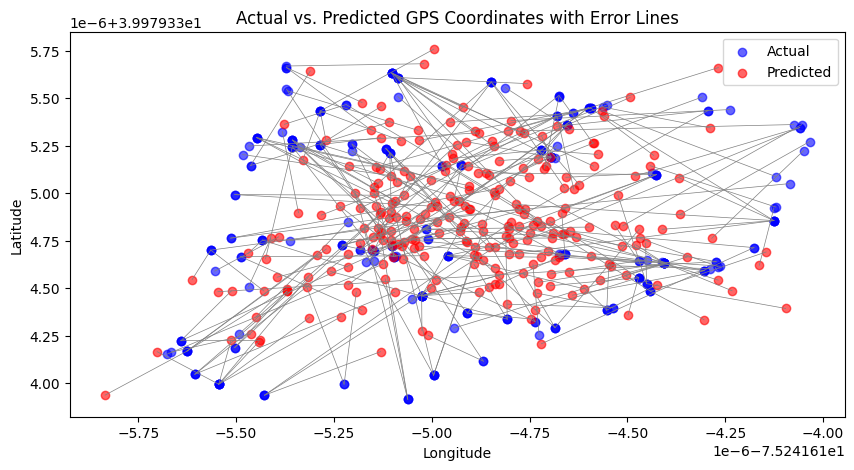

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot actual points
plt.scatter(all_actuals_denorm[:, 1], all_actuals_denorm[:, 0], label='Actual', color='blue', alpha=0.6)

# Plot predicted points
plt.scatter(all_preds_denorm[:, 1], all_preds_denorm[:, 0], label='Predicted', color='red', alpha=0.6)

# Draw lines connecting actual and predicted points
for i in range(len(all_actuals_denorm)):
    plt.plot(
        [all_actuals_denorm[i, 1], all_preds_denorm[i, 1]],
        [all_actuals_denorm[i, 0], all_preds_denorm[i, 0]],
        color='gray', linewidth=0.5
    )

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs. Predicted GPS Coordinates with Error Lines')
plt.show()

# 2. Pushing the model to the Hugging Face (Torchvision Model)

Use this code if you loaded the model from Torchvision or built the model from scratch using PyTorch. If you built your model from scratch, make sure to follow the guidelines described here - https://huggingface.co/docs/hub/en/models-uploading#upload-a-pytorch-model-using-huggingfacehub


You load this model by running

In [ ]:
import torch
resnet = torch.load("best_custom_model.pth")


C:\Users\Xiang\AppData\Local\Temp\ipykernel_46912\1161122022.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = torch.load("best_model.pth")


In [20]:
#load the parquet file
dataset_test = load_dataset("gydou/released_img", split="train")

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

In [22]:
print(resnet)

CustomResNetModel(
  (backbone): ResNetForImageClassification(
    (resnet): ResNetModel(
      (embedder): ResNetEmbeddings(
        (embedder): ResNetConvLayer(
          (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
        (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (encoder): ResNetEncoder(
        (stages): ModuleList(
          (0): ResNetStage(
            (layers): Sequential(
              (0): ResNetBottleNeckLayer(
                (shortcut): ResNetShortCut(
                  (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (layer): Sequential(
         

In [23]:
# Imports (add if not already present)
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from geopy.distance import geodesic
import torch

# 1. Wrap the HF dataset in your GPSImageDataset
test_dataset = GPSImageDataset(
    hf_dataset=dataset_test,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Run evaluation
resnet.eval()
all_preds = []
all_actuals = []
distances = []

with torch.no_grad():
    for images, coords in test_loader:
        images, coords = images.to(device), coords.to(device)
        outputs = resnet(images)

        # Denormalize back to degrees
        preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        actuals = coords.cpu()  * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

        for p, a in zip(preds, actuals):
            distances.append(geodesic((a[0].item(), a[1].item()),
                                     (p[0].item(), p[1].item())).meters)

# 3. Compute metrics
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

mae = mean_absolute_error(all_actuals, all_preds)
rmse = mean_squared_error(all_actuals, all_preds, squared=False)
avg_dist = sum(distances) / len(distances)

print(f"Test MAE (°): {mae:.4f}")
print(f"Test RMSE (°): {rmse:.4f}")
print(f"Avg geodesic distance (m): {avg_dist:.2f}")

Test MAE (°): 0.0004
Test RMSE (°): 0.0006
Avg geodesic distance (m): 69.02


# Loading and creating the actual test pictures into CSV

In [24]:
real_test = load_dataset("gydou/5190_Spring_Final_Hidden_Data_Released", split="test")

README.md:   0%|          | 0.00/356 [00:00<?, ?B/s]

c:\Users\Xiang\anaconda3\envs\cis5810-p7\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Xiang\.cache\huggingface\hub\datasets--gydou--5190_Spring_Final_Hidden_Data_Released. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


test-00000-of-00004.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

test-00001-of-00004.parquet:   0%|          | 0.00/346M [00:00<?, ?B/s]

test-00002-of-00004.parquet:   0%|          | 0.00/402M [00:00<?, ?B/s]

test-00003-of-00004.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [28]:
# ----------
# 0. Imports
# ----------
import csv
from pathlib import Path
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader
import torch
import numpy as np

# ----------
# 1. Dataset & loader (unchanged)
# ----------
test_dataset = GPSImageDataset(
    hf_dataset       = real_test,
    transform        = inference_transform,
    lat_mean         = lat_mean,
    lat_std          = lat_std,
    lon_mean         = lon_mean,
    lon_std          = lon_std,
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ----------
# 2. Evaluation & CSV collection
# ----------
resnet.eval()

scale = torch.tensor([lat_std, lon_std], device=device)
shift = torch.tensor([lat_mean, lon_mean], device=device)

pred_rows      = []       # rows to go into CSV
actual_rows    = []       # collect for metrics
geodesic_dists = []

with torch.no_grad():
    for imgs, coords in test_loader:
        imgs, coords = imgs.to(device), coords.to(device)

        # forward pass ➜ (B,2) tensor
        preds_norm = resnet(imgs)

        # denormalise on GPU, then bring to CPU once
        preds_deg   = (preds_norm * scale + shift).detach().cpu()
        actuals_deg = (coords     * scale + shift).detach().cpu()

        # add to running lists
        pred_rows.extend(preds_deg.tolist())
        actual_rows.extend(actuals_deg.tolist())

        for p, a in zip(preds_deg, actuals_deg):
            geodesic_dists.append(
                geodesic((a[0].item(), a[1].item()),
                         (p[0].item(), p[1].item())).meters
            )

# ----------
# 3. Metrics
# ----------
pred_arr   = np.array(pred_rows)
actual_arr = np.array(actual_rows)

mae   = mean_absolute_error(actual_arr, pred_arr)
rmse  = mean_squared_error(actual_arr, pred_arr, squared=False)
avg_d = np.mean(geodesic_dists)

print(f"Test MAE (°):           {mae:.4f}")
print(f"Test RMSE (°):          {rmse:.4f}")
print(f"Avg geodesic distance:  {avg_d:.2f} m")

# ----------
# 4. Write predictions → CSV
# ----------
csv_path = Path("predictions.csv")
with csv_path.open("w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Latitude", "Longitude"])       # header
    writer.writerows(pred_rows)

print(f"Saved {len(pred_rows)} predictions → {csv_path.resolve()}")


Test MAE (°):           57.5716
Test RMSE (°):          57.5716
Avg geodesic distance:  8752036.36 m
Saved 300 predictions → C:\Users\Xiang\Downloads\drive-download-20250422T155327Z-001\predictions.csv
